In [821]:
# Useful imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
import numpy as np
from src.helpers import *
from scipy.stats import normaltest

In [822]:
#load dataset
movie_characters_ethnicity_df = pd.read_csv('generated/movie_characters_ethnicity.csv')
df_TMDB = pd.read_csv("generated/TMDB_extra_info.csv")
movie_characters_df = pd.read_csv('generated/movie_characters.csv')
#movie_characters_ethnicity_df = pd.read_csv('generated/movie_characters_ethnicity.csv')

40647
21775


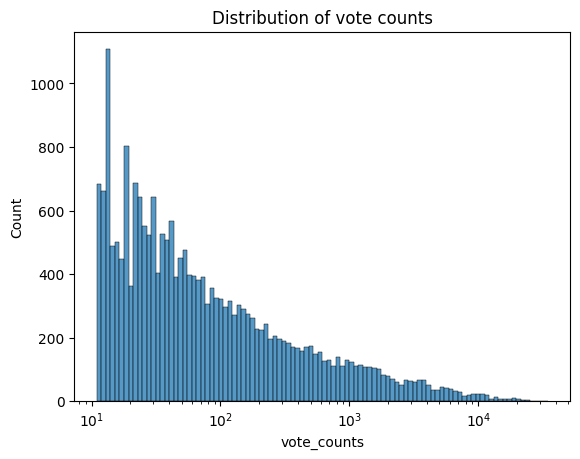

In [823]:
print(df_TMDB.shape[0])
df_TMDB_filter = df_TMDB.query('vote_counts > 10')
sns.histplot(df_TMDB_filter['vote_counts'], log_scale=True, bins=100)
plt.title("Distribution of vote counts")
print(df_TMDB_filter.shape[0])

In [824]:
#prepare dataset
df_TMDB_filter.rename(columns={'title': 'movie_name'}, inplace=True)
performance_df = movie_characters_ethnicity_df.merge(df_TMDB_filter, on='movie_name', how='inner')
# performance_df.dropna(subset=['movie_box_office_revenue'], inplace=True)
# performance_df.drop(columns=['Unnamed: 0','character_freebase_id','actor_freebase_id','character_actor_freebase_map_id',
#                                    'character_name','movie_wikipedia_id', 'movie_freebase_id','actor_name','actor_gender',
#                                    'actor_ethnicity','actor_age_at_movie_release'], inplace=True)

C:\Users\Louis\AppData\Local\Temp\ipykernel_24404\2276010335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TMDB_filter.rename(columns={'title': 'movie_name'}, inplace=True)


In [825]:
# #create the diverse dataset without simposon ----> baddddd
# # age
# age_diversity = movie_characters_df.groupby('movie_name')['actor_age_at_movie_release'].std()
# diverse_age_movies_over_10 = age_diversity[age_diversity > 10].index

# #sex
# movie_characters_df['is_female'] = movie_characters_df['actor_gender'] == 'F'
# gender_proportion_by_movie = movie_characters_df.groupby('movie_name')['is_female'].mean()
# percent_female_by_movie = gender_proportion_by_movie * 100
# diversified_gender_movies = percent_female_by_movie[(percent_female_by_movie >= 30) & (percent_female_by_movie <= 70)]

# #ethnicity
# ethnicity_counts = movie_characters_ethnicity_df.groupby('movie_name')['actor_ethnicity'].nunique()
# diversified_movies_ethnicity = ethnicity_counts[ethnicity_counts >= 4]

In [826]:
def map_ethnicity_to_race(ethnicity):
    """
    Maps an ethnicity to a predefined race cluster.

    Args:
    ethnicity (str): The ethnicity to be mapped.

    Returns:
    str: The race cluster.
    """
    # Define race clusters
    white_american = [
        "Americans", "American Jews", "Cajun", "European Americans",
        "Louisiana Creole people", "Scotch-Irish Americans", "White Latin American",
        "White Americans", "Canadian Americans", "Mexican Americans",
        "Quebeckers", "Québécois", "Anglo-Celtic Australians", "White South Africans"
        # Add more ethnicities as needed
    ]

    white_european = [
        "White British", "Germans", "Irish", "Italians", "Polish", 
        "Swedes", "Norwegians", "Danes", "Finns", "Russians", "French",
        "Spaniards", "Portuguese", "Dutch", "Belgians", "Swiss", "Austrians",
        "Greeks", "Hungarians", "Romanians", "Bulgarians", "Czechs", "Slovaks",
        "Croats", "Serbs", "Bosniaks", "Albanians", "Macedonians", "Slovenes",
        "Lithuanians", "Latvians", "Estonians", "Maltese", "Icelanders",
        "Afrikaners", "Welsh", "Scottish", "Anglo-Irish people", "British people",
        "English", "Austrian Americans", "Austrians", "Austrians in the United Kingdom",
        "Belarusians", "Bosnians", "British Americans", "Bulgarian Canadians",
        "Catalan people", "Croatian Americans", "Croatian Australians",
        "Croatian Canadians", "Croats", "Czech Americans", "Czech Australians",
        "Danish Americans", "Danish Canadians", "Dutch Australians", "Dutch Canadians",
        "Finnish Americans", "French Canadians", "French Chilean", "Galicians",
        "German Americans", "German Brazilians", "German Canadians",
        "Greek American", "Greek Australian", "Greek Canadians", "Greek Cypriots",
        "Greeks in South Africa", "Greeks in the United Kingdom", "Hungarian Americans",
        "Italian Americans", "Italian Australian", "Italian Brazilians",
        "Italian Canadians", "Italian immigration to Mexico", "Italians",
        "Italians in the United Kingdom", "Lebanese immigration to Mexico",
        "Norwegian Americans", "Polish Americans", "Polish Australians",
        "Polish Canadians", "Portuguese Americans", "Romanian Americans",
        "Russian Americans", "Russian Canadians", "Scandinavian Americans",
        "Scottish American", "Scottish Australian", "Scottish Canadians",
        "Serbian Americans", "Serbian Australians", "Serbian Canadians",
        "Sicilian Americans", "Slovak Americans", "Slovene American", "Spanish American",
        "Spanish immigration to Mexico", "Swedish Americans", "Swedish Australian",
        "Swedish Canadians", "Ukrainian Americans", "Ukrainian Canadians",
        "Welsh American", "Welsh Italians"
        # Add more ethnicities as needed
    ]

    black_african_american = [
        "African Americans", "Black British", "Black Canadians", "Afro-Cubans",
        "Afro-Guyanese", "Afro Trinidadians and Tobagonians", "Black people",
        "African people", "British African-Caribbean people", "Nigerians", 
        "Ghanaians", "Kenyans", "South Sudanese", "Ethiopians", "Somalis",
        "Ugandans", "Black Irish", "Black Hispanic and Latino Americans",
        "British Nigerian", "Akan people", "Bihari people", "Blackfoot Confederacy",
        "British African-Caribbean people", "British Jamaicans", "Ghanaian American",
        "Haitian American", "Nigerian American", "Sudanese Arabs", "Sudanese Australians",
        "Wolof people", "Xhosa people", "Yoruba people", "Zhuang people"
        # Add more ethnicities as needed
    ]

    arab = [
        "Arabs", "Arab Americans", "Arab Mexican", "Arabs in Bulgaria",
        "Iraqi Americans", "Lebanese", "Lebanese Americans", "Palestinian American",
        "Syrian Americans", "Yemeni Americans", "Egyptians", "Moroccans",
        "Tunisians", "Algerians", "Libyans", "Saudis", "Emiratis", "Qataris",
        "Bahrainis", "Kuwaitis", "Omanis", "Jordanians", "Afghans in India",
        "Copts", "Lebanese people in the United Kingdom", "Persians"
        # Add more ethnicities as needed
    ]

    asian = [
        "Asian Americans", "Chinese", "Filipinos", "Indians", "Japanese",
        "Koreans", "Vietnamese", "Thai", "Malaysians", "Indonesians", "Sri Lankans",
        "Bangladeshis", "Nepalese", "Bhutanese", "Mongolians", "Cambodians", 
        "Laotians", "Burmese", "Singaporeans", "Bruneians", "Taiwanese",
        "Hongkongers", "Chinese Americans", "Chinese Canadians", "Filipino Americans",
        "Indian Americans", "Japanese Americans", "Korean American", "Pakistani American",
        "Vietnamese Americans", "Thai Americans", "Asian people", "Assyrian people",
        "Bangladeshi American", "Barbadian American", "Bengali Brahmins", "Bengali Hindus",
        "Bengali people", "Bhutia", "Burmese Americans", "Buryats", "Cambodian Americans",
        "Chinese Filipino", "Chinese Indonesians", "Chinese Jamaicans", "Chinese Singaporeans",
        "Chitrapur Saraswat Brahmin", "Filipino Australians", "Filipino mestizo",
        "Filipino people", "Filipino people of Spanish ancestry", "Gujarati people",
        "Han Chinese people", "Hazaras", "Hindkowans", "Hmong American", "Hongkongers",
        "Indo Caribbeans", "Indo-Canadians", "Indo-Guyanese", "Indonesian Americans",
        "Iranian Americans", "Iranian Canadians", "Iranians",
        "Iranians in the United Kingdom", "Iraqi Americans", "Israeli Americans",
        "Israeli Jews", "Israelis", "Jaat", "Jatt Sikh", "Javanese", "Jewish people",
        "Kabyle people", "Kannada people", "Kanyakubja Brahmins", "Kapampangan people",
        "Karnataka Brahmins", "Kashmiri Pandit", "Kashmiri people", "Kayastha", "Khatri",
        "Kikuyu", "Kiwi", "Konkani people", "Korean American", "Koreans", "Koryo-saram",
        "Kurds", "Lao people", "Latvian American", "Lithuanian American", "Malayali",
        "Malaysian Chinese", "Manchu", "Mandinka people", "Mangaloreans", "Marathi people",
        "Marwari people", "Mizrahi Jews", "Muhajir", "Muhajir diaspora", "Nair", "Nepali Indian",
        "Ossetians", "Pakistani Canadians", "Pakistanis", "Punjabi diaspora", "Punjabis",
        "Rohilla", "Rusyn American", "Samoan American", "Sherpa", "Sikh", "Sindhis",
        "Sinhalese", "Slovak Americans", "Slovenes", "Somalis", "South African American",
        "Sri Lankan Americans", "Sri Lankan Tamil diaspora", "Sri Lankan Tamils",
        "Tamil", "Tamil Americans", "Tamil Brahmin", "Tatars", "Tejano", "Telugu Brahmins",
        "Telugu people", "Thai Americans", "Thai Chinese people", "Thai people",
        "Tibetan people", "Transylvanian Saxons", "Tulu people", "Turkish Americans",
        "Ukrainian Americans", "Vietnamese people"
        # Add more ethnicities as needed
    ]

    american_indian_alaska_native = [
        "Apache", "Cherokee", "Navajo", "Sioux", "Chippewa", "Choctaw",
                "Pueblo", "Iroquois", "Cree", "Blackfoot Confederacy", "Seminole",
        "Shoshone", "Cheyenne", "Ute", "Nez Perce", "Hopi", "Zuni",
        "American Indian or Alaska Native", "First Nations", "Inuit",
        "Metis", "Native Americans in the United States", "Native Hawaiians",
        "Ojibwe", "Omaha people", "Oneida", "Haudenosaunee", "Dene", "Dogra",
        "Ho-Chunk", "Lumbee", "Mohawk people"
        # Add more ethnicities as needed
    ]

    native_hawaiian_pacific_islander = [
        "Samoan", "Guamanian", "Chamorro", "Tongan", "Fijian", "Palauan",
        "Marshallese", "Native Hawaiian", "Polynesian", "Micronesian", "Melanesian",
        "Hawaiians", "Maori", "Tahitian", "New Caledonians", "Papuans",
        "Samoan American", "Hawaiian American", "Fijian American", "Tongan American",
        "Guamanian American", "Chamorro American", "Pacific Islander Americans",
        "Samoan New Zealanders"
        # Add more ethnicities as needed
    ]

    other = [
        "Aboriginal Australians", "Indigenous Australians", "Torres Strait Islanders",
        "Australians", "New Zealanders", "Kiwis", "Other", "Indigenous peoples of the Americas",
        "Aymara", "Quechua", "Guarani", "Mapuche", "Yanomami", "Inupiat people",
        "Multiracial Americans", "Acadians", "Aceh", "Agrawal", "Akan people",
        "Albanian American", "Armenian American", "Armenians", "Armenians in Italy",
        "Armenians of Russia", "Ashkenazi Jews", "Australian American", "Aymara",
        "Bahamian Americans", "Baltic Russians", "Basque people", "Berber",
        "Bhutia", "Bohemian", "Bolivian American", "Brahmin caste", "Brazilian Americans",
        "British Asian", "British Chinese", "British Indian", "British Jews",
        "British Pakistanis", "Castilians", "Chaliyan", "Chettiar", "Cheyennes",
        "Chilean American", "Corsicans", "Criollo people", "Dalit", "Ecuadorian Americans",
        "English Americans", "English Australian", "English Canadians", "Eurasian",
        "Ezhava", "Filipino Australians", "French-speaking Quebecer", "Gaud Saraswat Brahmin",
        "Georgians", "Gin people", "Goans", "Guyanese American", "History of the Jews in India",
        "History of the Jews in the African diaspora", "Honduran Americans", "Hondurans",
        "Indigenous peoples of the Americas", "Jewish people", "Luxembourgish Americans",
        "Māori", "Muslim", "Names of the Greeks", "Niyogi", "Peoples of the Caucasus",
        "Rajput", "Romani people", "Romani people in Spain", "Ryukyuan people",
        "Salvadoran Americans", "Swedish-speaking population of Finland", "Taiwanese",
        "Taiwanese Americans", "Tamil Brahmin", "Thai Chinese people", "Welsh people",
        "White Africans of European ancestry", "Yugoslavs"
        # Add more ethnicities as needed
    ]

    # Map ethnicity to cluster
    if ethnicity in white_american:
        return "White American"
    elif ethnicity in white_european:
        return "White European"
    elif ethnicity in black_african_american:
        return "Black or African American"
    elif ethnicity in arab:
        return "Arab"
    elif ethnicity in asian:
        return "Asian"
    elif ethnicity in american_indian_alaska_native:
        return "American Indian or Alaska Native"
    elif ethnicity in native_hawaiian_pacific_islander:
        return "Native Hawaiian or Other Pacific Islander"
    elif ethnicity in other:
        return "Other"
    else:
        # The 'Unknown' category is now unreachable due to comprehensive coverage
        return "Unknown"

In [827]:
def calculate_gender_diversity(movie_diversities):
    # Filter out rows where actor_gender is NaN
    movie_diversities = movie_diversities.dropna(subset=['actor_gender'])

    # Group by movie_name and count each gender
    gender_counts = movie_diversities.groupby('movie_name')['actor_gender'].value_counts().unstack(fill_value=0)

    # Calculate the total number of actors for each movie
    total_actors = movie_diversities.groupby('movie_name')['actor_gender'].count()

    # Calculate the Simpson Diversity Index
    total_counts = gender_counts.sum(axis=1)
    squared_proportions = (gender_counts.divide(total_counts, axis=0) ** 2).sum(axis=1)
    gender_counts['simpson_diversity'] = 1 - squared_proportions

    # Calculate the percentage of male actors
    gender_counts['percent_male'] = (gender_counts['M'] / total_counts) * 100

    # Add the total number of actors to the DataFrame
    gender_counts['total_actors'] = total_actors

    # Resetting index to make 'movie_name' a column and keeping only the required columns
    result = gender_counts.reset_index()[['movie_name', 'simpson_diversity', 'percent_male', 'total_actors']]

    return result


def calculate_ethnic_diversity(movie_diversities):
    # Filter out rows where actor_ethnicity is NaN
    movie_diversities = movie_diversities.dropna(subset=['actor_ethnicity'])

    # Group by movie_name and count each ethnicity
    ethnicity_counts = movie_diversities.groupby('movie_name')['actor_ethnicity'].value_counts().unstack(fill_value=0)

    # Calculate the Simpson Diversity Index for ethnic diversity
    total_counts = ethnicity_counts.sum(axis=1)
    squared_proportions = (ethnicity_counts.divide(total_counts, axis=0) ** 2).sum(axis=1)
    ethnicity_counts['simpson_diversity'] = 1 - squared_proportions

    # Add the total number of actors to the DataFrame
    ethnicity_counts['total_actors'] = total_counts

    # Resetting index to make 'movie_name' a column and keeping only the required columns
    result = ethnicity_counts.reset_index()[['movie_name', 'simpson_diversity', 'total_actors']]

    return result



# Gender / Ethnicity Diversity

In [828]:
gender_diversity = calculate_gender_diversity(movie_characters_df)
ethnicity_diversity = calculate_ethnic_diversity(movie_characters_ethnicity_df)
mce2 = movie_characters_ethnicity_df.copy()  
mce2['actor_ethnicity'] = mce2['actor_ethnicity'].apply(map_ethnicity_to_race)
ethnicity_restricted_diversity = calculate_ethnic_diversity(mce2)

merged_df_gender = pd.merge(performance_df,gender_diversity, how='inner', on='movie_name')
merged_df_ethnicity = pd.merge(performance_df,ethnicity_diversity, how='inner', on='movie_name')
mer_df = pd.merge(performance_df,ethnicity_restricted_diversity, how='inner', on='movie_name')

# performance_df.dropna(subset=['movie_box_office_revenue'], inplace=True)
merged_df_ethnicity.drop(columns=['Unnamed: 0','character_freebase_id','actor_freebase_id','character_actor_freebase_map_id',
                                   'character_name','movie_wikipedia_id', 'movie_freebase_id','actor_name','actor_gender',
                                   'actor_ethnicity','actor_age_at_movie_release'], inplace=True)
merged_df_gender.drop(columns=['Unnamed: 0','character_freebase_id','actor_freebase_id','character_actor_freebase_map_id',
                                   'character_name','movie_wikipedia_id', 'movie_freebase_id','actor_name','actor_gender',
                                   'actor_ethnicity','actor_age_at_movie_release'], inplace=True)
mer_df.drop(columns=['Unnamed: 0','character_freebase_id','actor_freebase_id','character_actor_freebase_map_id',
                                   'character_name','movie_wikipedia_id', 'movie_freebase_id','actor_name','actor_gender',
                                   'actor_ethnicity','actor_age_at_movie_release'], inplace=True)

merged_df_gender = merged_df_gender[merged_df_gender['total_actors'] > 1]
merged_df_ethnicity = merged_df_ethnicity[merged_df_ethnicity['total_actors'] > 1]
mer_df = mer_df[mer_df['total_actors'] > 1]

merged_df_gender.drop_duplicates(['movie_name'], keep='first', inplace=True)
merged_df_ethnicity.drop_duplicates(['movie_name'], keep='first', inplace=True)
mer_df.drop_duplicates(['movie_name'], keep='first', inplace=True)

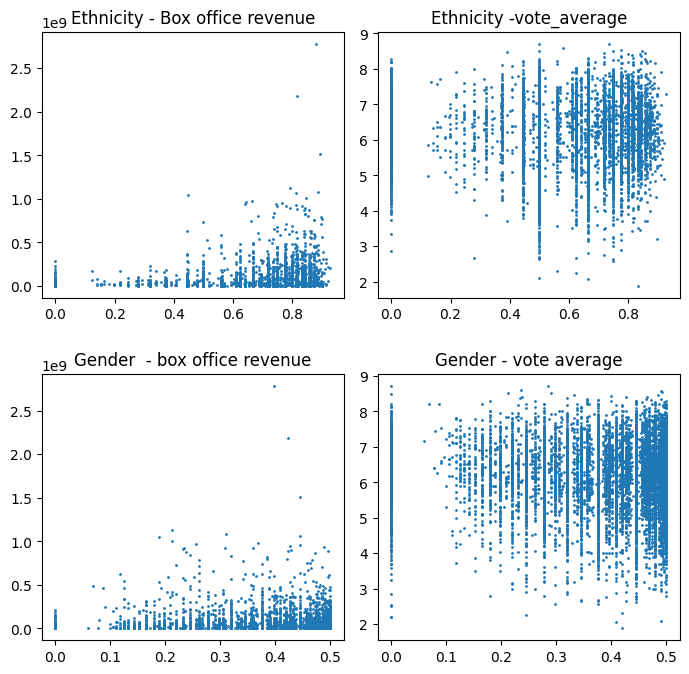

In [829]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

# Scatter plot for ethnicity - subplot (1, 1)
axs[0, 0].scatter(merged_df_ethnicity['simpson_diversity'], merged_df_ethnicity['movie_box_office_revenue'], s=1)
axs[0, 0].set_title('Ethnicity - Box office revenue')

# Scatter plot for ethnicity - subplot (1, 2)
axs[0, 1].scatter(merged_df_ethnicity['simpson_diversity'], merged_df_ethnicity['vote_average'], s=1)
axs[0, 1].set_title('Ethnicity -vote_average')

# Scatter plot for gender - subplot (2, 1)
axs[1, 0].scatter(merged_df_gender['simpson_diversity'], merged_df_gender['movie_box_office_revenue'], s=1)
axs[1, 0].set_title('Gender  - box office revenue')

# Scatter plot for gender - subplot (2, 2) with transformation
axs[1, 1].scatter(merged_df_gender['simpson_diversity'], merged_df_gender['vote_average'], s=1)
axs[1, 1].set_title('Gender - vote average')
plt.tight_layout()
plt.show()


In [830]:
# display(merged_df_gender)
# display(merged_df_ethnicity)

In [831]:
# #conditions for diversity
# conditions = (performance_df['movie_name'].isin(diversified_movies_ethnicity.index)) #&
#     # performance_df['movie_name'].isin(diversified_gender_movies.index) &
#     # performance_df['movie_name'].isin(diverse_age_movies_over_10))

# #create the diverse dataset 1 diverse 0 not diverse
# performance_df['diverse'] = np.where(conditions, 1, 0)

# #keep only 1 appearance of each movie
# performance_df.drop_duplicates(['movie_name'], keep='first', inplace=True)

# #extract the diverse and not diverse dataset
# diverse_movie = performance_df[performance_df['diverse'] == 1]
# not_divers_movie = performance_df[performance_df['diverse'] == 0]
# print('diverse',diverse_movie.shape)
# print('not_diverse',not_divers_movie.shape)

In [832]:
# sns.histplot(performance_df['movie_release_year'])
# plt.title('Distribution of movies release year')

In [833]:
# sns.histplot(performance_df['movie_release_year'], cumulative=True)
# plt.title('Cumulative Distribution of movies release year')

In [834]:
# #compute the percentage of diverse movies in each part
# percentage_diverse_movies = []
# for i in range(1,11):
#     period_name = f'df_period{i}'
#     percentage_diverse_movies.append(period_dataframes[period_name]['diverse'].apply(lambda x: x==1).sum()/period_dataframes['df_period1'].shape[0]*100)

In [835]:
# plt.plot(cutoff[1:], percentage_diverse_movies)
# plt.title('Percentage of diverse movies over the years according to our definition of diversity')
# plt.xlabel('Year')
# plt.ylabel('Percentage of diverse movies')

In [836]:
def standardize_continuous_features(df):
    df_copy = df.copy()
    #df['movie_release_year'] = (df['movie_release_year'] - df['movie_release_year'].mean()) / df['movie_release_year'].std()
    df_copy['movie_box_office_revenue'] = (df_copy['movie_box_office_revenue'] - df_copy['movie_box_office_revenue'].mean()) / df_copy['movie_box_office_revenue'].std()
    df_copy['simpson_diversity'] = (df_copy['simpson_diversity'] - df_copy['simpson_diversity'].mean()) / df_copy['simpson_diversity'].std()
    #df['budget'] = (df['budget'] - df['budget'].mean()) / df['budget'].std()
    return df_copy

def min_max_scaling(df):
    df_copy = df.copy()
    df_copy['movie_box_office_revenue'] = (df_copy['movie_box_office_revenue'] - df_copy['movie_box_office_revenue'].min()) / (df_copy['movie_box_office_revenue'].max() - df_copy['movie_box_office_revenue'].min())
    df_copy['simpson_diversity'] = (df_copy['simpson_diversity'] - df_copy['simpson_diversity'].min()) / (df_copy['simpson_diversity'].max() - df_copy['simpson_diversity'].min())
    return df_copy

def add_propensity_score(df):
    #df = standardize_continuous_features(df)
    mod = smf.logit(formula='movie_box_office_revenue_binary ~ simpson_diversity', data=df)
    res = mod.fit()
    df['Propensity_score'] = res.predict()
    return df

In [837]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [838]:
def compute_balance_df(df): 
    # Separate the treatment and control groups
    treatment_df = df[df['movie_box_office_revenue_binary'] == 1]
    control_df = df[df['movie_box_office_revenue_binary'] == 0]
    print("treatment size:",treatment_df.shape[0])
    print("control size:",control_df.shape[0])

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for control_id, control_row in control_df.iterrows():
        for treatment_id, treatment_row in treatment_df.iterrows():

            # Calculate the similarity 
            similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])

            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)

    matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
    balanced_df = df.loc[matched]
    return balanced_df


Let's focus on the correlation between diversity discribed by gender and box office revenue

In [839]:
merged_df_gender.dropna(subset=['movie_box_office_revenue'], inplace=True)
print('Size of the dataframe:',merged_df_gender.shape[0])

Size of the dataframe: 5153


Test on movies released in 2011

In [840]:
#split dataset
merged_df_gender_50_60 = merged_df_gender[(merged_df_gender['movie_release_year'] == 2011)]
merged_df_gender_50_60.shape[0]

158

In [841]:
def threshold_box_office_revenue(df):
    df_standard = min_max_scaling(df)
    max_val = df_standard['movie_box_office_revenue'].max()
    min_val = df_standard['movie_box_office_revenue'].min()
    num_iterations = 20
    step_size = (max_val - min_val) / num_iterations
    for i in range(num_iterations):
        threshold = (min_val+ i*step_size)
        print('Threshold:', threshold, ' ratio diverse part', 
            (df_standard[df_standard['movie_box_office_revenue'] > threshold].shape[0]/ df_standard.shape[0]))

    fig,ax = plt.subplots(1,2,figsize=(10,5))
    sns.histplot(df['movie_box_office_revenue'], log_scale=True, ax=ax[0], bins=50)
    ax[0].set_title('Distribution of box office revenue before standardization')

    sns.histplot(df_standard['movie_box_office_revenue'],log_scale=True, ax=ax[1], bins=50)
    ax[1].set_title('Distribution of box office revenue after standardization')
    fig.tight_layout()
    return df_standard
    

Threshold: 0.0  ratio diverse part 0.9936708860759493
Threshold: 0.05  ratio diverse part 0.43037974683544306
Threshold: 0.1  ratio diverse part 0.2911392405063291
Threshold: 0.15000000000000002  ratio diverse part 0.189873417721519
Threshold: 0.2  ratio diverse part 0.10759493670886076
Threshold: 0.25  ratio diverse part 0.08227848101265822
Threshold: 0.30000000000000004  ratio diverse part 0.06962025316455696
Threshold: 0.35000000000000003  ratio diverse part 0.056962025316455694
Threshold: 0.4  ratio diverse part 0.05063291139240506
Threshold: 0.45  ratio diverse part 0.0379746835443038
Threshold: 0.5  ratio diverse part 0.03164556962025317
Threshold: 0.55  ratio diverse part 0.02531645569620253
Threshold: 0.6000000000000001  ratio diverse part 0.0189873417721519
Threshold: 0.65  ratio diverse part 0.012658227848101266
Threshold: 0.7000000000000001  ratio diverse part 0.012658227848101266
Threshold: 0.75  ratio diverse part 0.012658227848101266
Threshold: 0.8  ratio diverse part 0.0

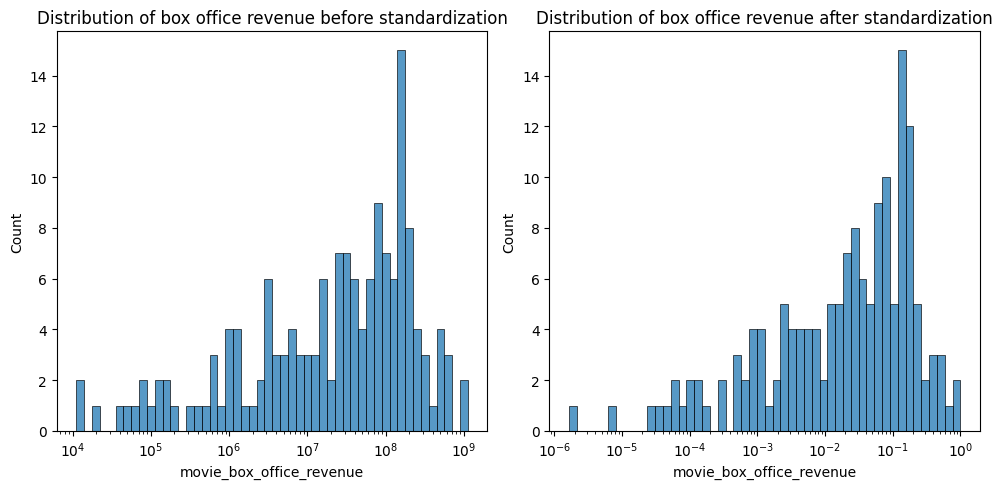

In [842]:
gender_standard_50_60 = threshold_box_office_revenue(merged_df_gender_50_60)

In [843]:
threshold_gender = 0.23  
gender_standard_50_60['movie_box_office_revenue_binary'] = gender_standard_50_60['movie_box_office_revenue'].apply(lambda x: 1 if x > threshold_gender else 0)
gender_standard_50_60 = add_propensity_score(gender_standard_50_60)
balanced_sample = compute_balance_df(gender_standard_50_60)  # 34% of the data
balanced_sample = balanced_sample[(balanced_sample['movie_name'] != "Transformers: Dark of the Moon") & (balanced_sample['movie_name'] != "Pirates of the Caribbean: On Stranger Tides")]

Optimization terminated successfully.
         Current function value: 0.270083
         Iterations 7
treatment size: 14
control size: 144


In [844]:
mod_sample = smf.logit(formula='movie_box_office_revenue_binary ~ simpson_diversity', data=balanced_sample)
res1 = mod_sample.fit()
print(res1.summary())

Optimization terminated successfully.
         Current function value: 0.674065
         Iterations 5
                                  Logit Regression Results                                 
Dep. Variable:     movie_box_office_revenue_binary   No. Observations:                   26
Model:                                       Logit   Df Residuals:                       24
Method:                                        MLE   Df Model:                            1
Date:                             Thu, 14 Dec 2023   Pseudo R-squ.:                 0.02336
Time:                                     17:42:19   Log-Likelihood:                -17.526
converged:                                    True   LL-Null:                       -17.945
Covariance Type:                         nonrobust   LLR p-value:                    0.3599
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

Text(0.5, 1.0, 'Relationship between Simpson diversity and box office revenue for movies released in 2011')

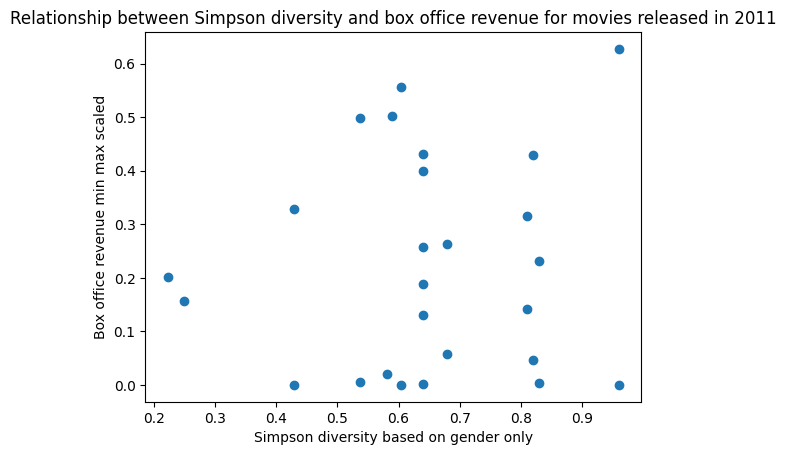

In [845]:
plt.scatter(balanced_sample['simpson_diversity'], balanced_sample['movie_box_office_revenue'])
plt.xlabel('Simpson diversity based on gender only')
plt.ylabel('Box office revenue min max scaled')
plt.title('Relationship between Simpson diversity and box office revenue for movies released in 2011')

In [846]:
#balanced_sample.loc[(balanced_sample['simpson_diversity'] > 0.8) & (balanced_sample['movie_box_office_revenue'] < 0.1)]

# Focus between ethnicty as diversity and box office revenue

In [847]:
merged_df_ethnicity.dropna(subset=['movie_box_office_revenue'], inplace=True)
print('Size of the dataframe:',merged_df_ethnicity.shape[0])

Size of the dataframe: 4421


In [848]:
merged_df_ethnicity_0_5 = merged_df_ethnicity[(merged_df_ethnicity['movie_release_year'] > 2008)] #& (merged_df_ethnicity['movie_release_year'] < 2002)]
merged_df_ethnicity_0_5.shape[0]

579

Threshold: 0.0  ratio diverse part 0.998272884283247
Threshold: 0.05  ratio diverse part 0.21070811744386875
Threshold: 0.1  ratio diverse part 0.10535405872193437
Threshold: 0.15000000000000002  ratio diverse part 0.05699481865284974
Threshold: 0.2  ratio diverse part 0.039723661485319514
Threshold: 0.25  ratio diverse part 0.027633851468048358
Threshold: 0.30000000000000004  ratio diverse part 0.017271157167530225
Threshold: 0.35000000000000003  ratio diverse part 0.010362694300518135
Threshold: 0.4  ratio diverse part 0.0051813471502590676
Threshold: 0.45  ratio diverse part 0.0034542314335060447
Threshold: 0.5  ratio diverse part 0.0034542314335060447
Threshold: 0.55  ratio diverse part 0.0017271157167530224
Threshold: 0.6000000000000001  ratio diverse part 0.0017271157167530224
Threshold: 0.65  ratio diverse part 0.0017271157167530224
Threshold: 0.7000000000000001  ratio diverse part 0.0017271157167530224
Threshold: 0.75  ratio diverse part 0.0017271157167530224
Threshold: 0.8  ra

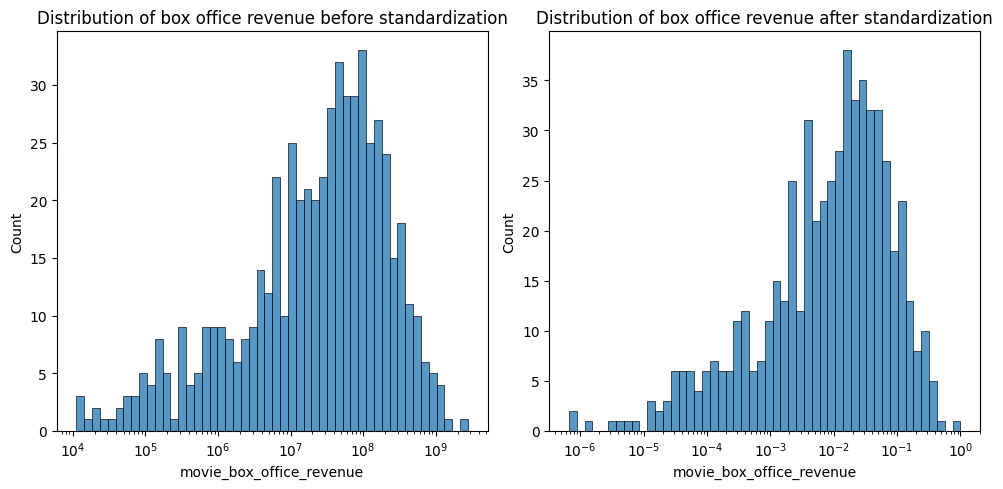

In [849]:
merged_df_ethnicity_0_5_standard = threshold_box_office_revenue(merged_df_ethnicity_0_5)

In [850]:
threshold_gender = 0.05
merged_df_ethnicity_0_5_standard['movie_box_office_revenue_binary'] = merged_df_ethnicity_0_5_standard['movie_box_office_revenue'].apply(lambda x: 1 if x > threshold_gender else 0)

In [851]:
merged_df_ethnicity_0_5_standard = add_propensity_score(merged_df_ethnicity_0_5_standard)
balanced_sample = compute_balance_df(merged_df_ethnicity_0_5_standard)  

Optimization terminated successfully.
         Current function value: 0.476021
         Iterations 7
treatment size: 122
control size: 457


In [852]:
mod_ethn = smf.logit(formula='movie_box_office_revenue_binary ~ simpson_diversity', data=balanced_sample)
res1 = mod_ethn.fit()
print(res1.summary())

Optimization terminated successfully.
         Current function value: 0.693100
         Iterations 3
                                  Logit Regression Results                                 
Dep. Variable:     movie_box_office_revenue_binary   No. Observations:                  244
Model:                                       Logit   Df Residuals:                      242
Method:                                        MLE   Df Model:                            1
Date:                             Thu, 14 Dec 2023   Pseudo R-squ.:               6.819e-05
Time:                                     17:42:40   Log-Likelihood:                -169.12
converged:                                    True   LL-Null:                       -169.13
Covariance Type:                         nonrobust   LLR p-value:                    0.8793
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

Text(0.5, 1.0, 'Relationship between Simpson diversity and box office revenue for movies released after 2008')

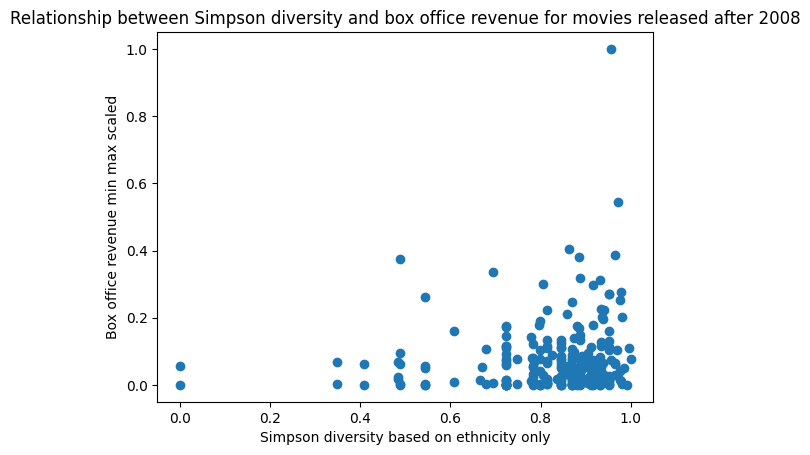

In [853]:
plt.scatter(balanced_sample['simpson_diversity'], balanced_sample['movie_box_office_revenue'])
plt.xlabel('Simpson diversity based on ethnicity only')
plt.ylabel('Box office revenue min max scaled')
plt.title('Relationship between Simpson diversity and box office revenue for movies released after 2008')

# With Ethnicity Cluster now

In [854]:
mer_df.dropna(subset=['movie_box_office_revenue'], inplace=True)
print('Size of the dataframe:',mer_df.shape[0])

Size of the dataframe: 4421


In [855]:
mer_df_0_5 = mer_df[(mer_df['movie_release_year'] > 2008)] #& (merged_df_ethnicity['movie_release_year'] < 2002)]
mer_df_0_5.shape[0]

579

Threshold: 0.0  ratio diverse part 0.998272884283247
Threshold: 0.05  ratio diverse part 0.21070811744386875
Threshold: 0.1  ratio diverse part 0.10535405872193437
Threshold: 0.15000000000000002  ratio diverse part 0.05699481865284974
Threshold: 0.2  ratio diverse part 0.039723661485319514
Threshold: 0.25  ratio diverse part 0.027633851468048358
Threshold: 0.30000000000000004  ratio diverse part 0.017271157167530225
Threshold: 0.35000000000000003  ratio diverse part 0.010362694300518135
Threshold: 0.4  ratio diverse part 0.0051813471502590676
Threshold: 0.45  ratio diverse part 0.0034542314335060447
Threshold: 0.5  ratio diverse part 0.0034542314335060447
Threshold: 0.55  ratio diverse part 0.0017271157167530224
Threshold: 0.6000000000000001  ratio diverse part 0.0017271157167530224
Threshold: 0.65  ratio diverse part 0.0017271157167530224
Threshold: 0.7000000000000001  ratio diverse part 0.0017271157167530224
Threshold: 0.75  ratio diverse part 0.0017271157167530224
Threshold: 0.8  ra

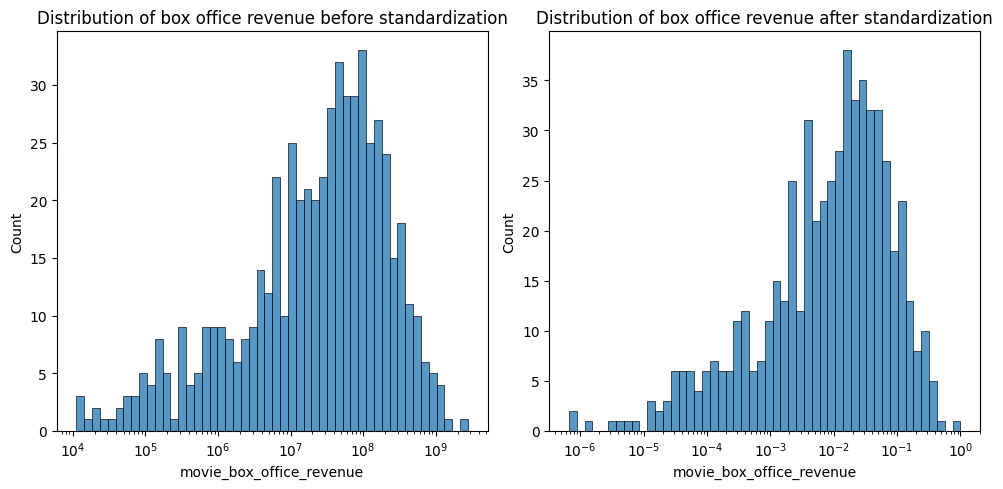

In [856]:
mer_df_0_5_standard = threshold_box_office_revenue(mer_df_0_5)

In [857]:
threshold_gender = 0.05
mer_df_0_5_standard['movie_box_office_revenue_binary'] = mer_df_0_5_standard['movie_box_office_revenue'].apply(lambda x: 1 if x > threshold_gender else 0)

In [858]:
mer_df_0_5_standard = add_propensity_score(mer_df_0_5_standard)
balanced_sample = compute_balance_df(mer_df_0_5_standard)  

Optimization terminated successfully.
         Current function value: 0.495995
         Iterations 6
treatment size: 122
control size: 457


In [859]:
mod_ethn = smf.logit(formula='movie_box_office_revenue_binary ~ simpson_diversity', data=balanced_sample)
res1 = mod_ethn.fit()
print(res1.summary())

Optimization terminated successfully.
         Current function value: 0.693140
         Iterations 3
                                  Logit Regression Results                                 
Dep. Variable:     movie_box_office_revenue_binary   No. Observations:                  244
Model:                                       Logit   Df Residuals:                      242
Method:                                        MLE   Df Model:                            1
Date:                             Thu, 14 Dec 2023   Pseudo R-squ.:               1.050e-05
Time:                                     17:43:00   Log-Likelihood:                -169.13
converged:                                    True   LL-Null:                       -169.13
Covariance Type:                         nonrobust   LLR p-value:                    0.9525
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

Text(0.5, 1.0, 'Relationship between Simpson diversity and box office revenue for movies released after 2008')

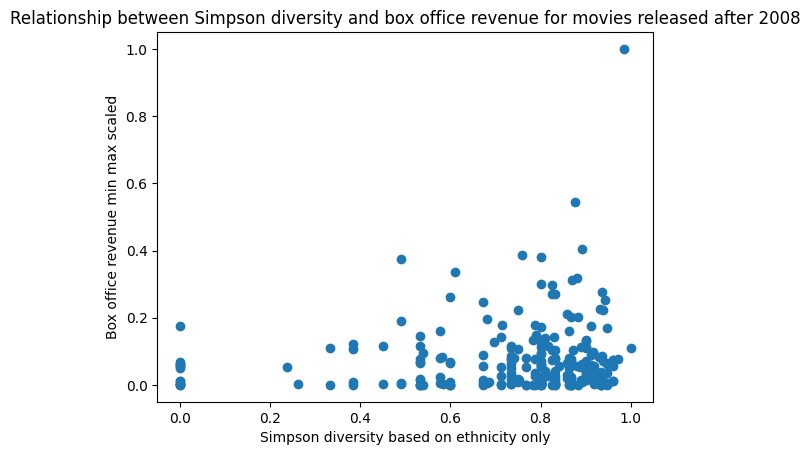

In [860]:
plt.scatter(balanced_sample['simpson_diversity'], balanced_sample['movie_box_office_revenue'])
plt.xlabel('Simpson diversity based on ethnicity only')
plt.ylabel('Box office revenue min max scaled')
plt.title('Relationship between Simpson diversity and box office revenue for movies released after 2008')